## <center>Методи та технології аналітики даних</center>
## <center>Лабораторна робота №3</center>
#### <center>ФБ-25 Кравченко Максим</center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Завантаження та підготовка даних

In [2]:
file_name = r'..\Dataset\adult_cleaned.data'
headers = ['Age', 'Work_class', 'Final_weight', 'Education', 'Education_num', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_gain', 'Capital_loss', 
           'Hours_per_week', 'Native_country', 'Income']
df = pd.read_csv(file_name, sep=",", header=1, names=headers, na_values='?')
df

,Age,Work_class,Final_weight,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
1,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
2,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
3,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
4,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30154,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
30155,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
30156,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
30157,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Надати оптимальну кількість кластерів методом ліктя. Намалювати графік, який відображає оптимальність кластерів);

<b>SSE</b> (Sum of Squared Errors) — це метрика, що використовується для оцінки якості кластеризації. Вона обчислюється як сума квадратів відстаней між кожною точкою та центроїдом її кластера. Чим менше значення SSE, тим більш компактні кластери.

<b>Метод ліктя</b> використовується для визначення оптимальної кількості кластерів (k) у K-means кластеризації. Ідея полягає в тому, щоб знайти точку на графіку залежності SSE від кількості кластерів, де відбувається різкий злам (лікоть). Це показує, що додавання більше кластерів не дає значного покращення якості кластеризації.

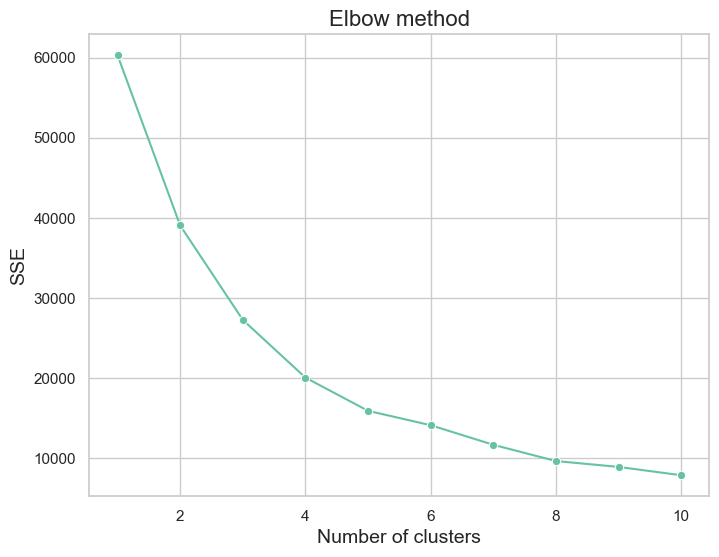

In [3]:
columns_to_use = ['Age', 'Hours_per_week']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[columns_to_use])

sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

sns.set_theme(style="whitegrid")

palette = sns.color_palette("Set2")

plt.figure(figsize=(8, 6))
sns.lineplot(x=range(1, 11), y=sse, marker='o', color=palette[0])

plt.title('Elbow method', fontsize=16)
plt.xlabel('Number of clusters', fontsize=14)
plt.ylabel('SSE', fontsize=14)

plt.show()

Надати таблицю з центрами кластерів та кількістю елементів;

In [4]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_data)

cluster_centers = kmeans.cluster_centers_

df['Cluster'] = kmeans.labels_

cluster_counts = df['Cluster'].value_counts().sort_index()

centers_and_counts = pd.DataFrame(cluster_centers, columns=columns_to_use)
centers_and_counts['Cluster_size'] = cluster_counts.values

centers_and_counts

,Age,Hours_per_week,Cluster_size
0,1.124798,-0.156438,9450
1,-1.047697,-1.688356,3114
2,0.164043,1.903226,3128
3,-0.544583,0.054073,14467


Намалювати кластери різними кольорами на одній сітці та їх центри;

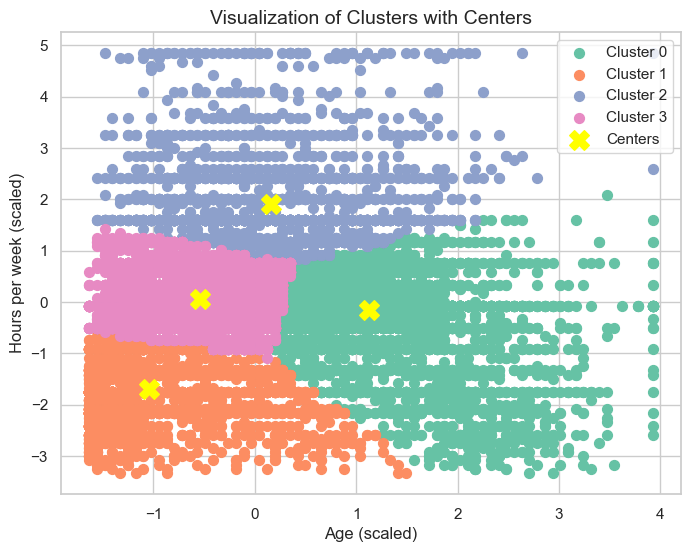

In [5]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))

for cluster in range(4):
    cluster_data = scaled_data[df['Cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                s=50, c=[palette[cluster]], label=f'Cluster {cluster}')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='yellow', marker='X', label='Centers')

plt.xlabel('Age (scaled)', fontsize=12)
plt.ylabel('Hours per week (scaled)', fontsize=12)
plt.title('Visualization of Clusters with Centers', fontsize=14)

plt.legend()

plt.show()

Визначення радіуса кожного кластера (метрика - евклідова відстань);

In [6]:
cluster_radii = []
for cluster in range(4):
    cluster_data = scaled_data[df['Cluster'] == cluster]
    distances = np.linalg.norm(cluster_data - centers[cluster], axis=1)
    cluster_radii.append(np.mean(distances))

for i, radius in enumerate(cluster_radii):
    print(f'Cluster {i} average radius (Euclidean distance): {radius:.2f}')

Cluster 0 average radius (Euclidean distance): 0.75
Cluster 1 average radius (Euclidean distance): 0.74
Cluster 2 average radius (Euclidean distance): 0.96
Cluster 3 average radius (Euclidean distance): 0.56


Намалювати дендограму;

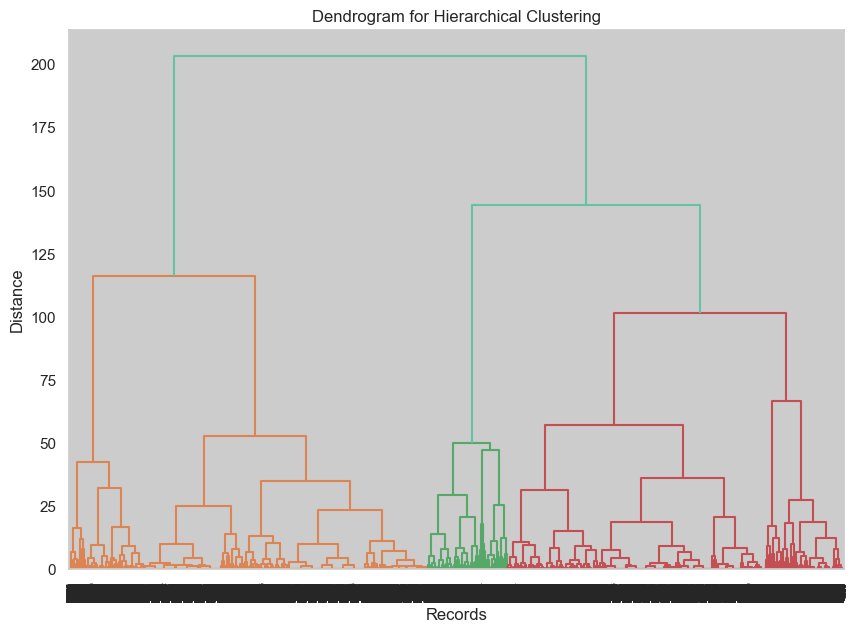

In [10]:
Z = linkage(scaled_data, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(Z, color_threshold=None, above_threshold_color=palette[0])

plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Records')
plt.ylabel('Distance')

plt.show()

Надати таблицю з кількістю елементів по кластерам;
<br>Порівняти кількіть та збалансованість кластерів в цих двох кластерних анаізів.

In [11]:
n_clusters = 4
hierarchical_clusters = fcluster(Z, n_clusters, criterion='maxclust')

df['Hierarchical_Cluster'] = hierarchical_clusters - 1

hierarchical_cluster_counts = df['Hierarchical_Cluster'].value_counts().sort_index()

comparison_table = pd.DataFrame({
    'K-Means_Cluster_Size': df['Cluster'].value_counts().sort_index().values,
    'Hierarchical_Cluster_Size': hierarchical_cluster_counts.values
})

total_elements = len(df)

comparison_table['K-Means_Percentage'] = (comparison_table['K-Means_Cluster_Size'] / total_elements) * 100
comparison_table['Hierarchical_Percentage'] = (comparison_table['Hierarchical_Cluster_Size'] / total_elements) * 100

comparison_table

,K-Means_Cluster_Size,Hierarchical_Cluster_Size,K-Means_Percentage,Hierarchical_Percentage
0,9450,2942,31.333930,9.754965
1,3114,11004,10.325276,36.486621
2,3128,3097,10.371697,10.268908
3,14467,13116,47.969097,43.489506
